In [96]:
# Deep convolutional generative adversarial network 
# Make this code multi GPU trainable
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from glob import glob
import cv2

# transformation that needs to be applied on the input image 
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,)), # this transforms the data between -1 and 1
# ])

BATCH_SIZE = 4
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# # device = 'cpu'

# dataset = torchvision.datasets.MNIST(root='.', download=False, transform=transform)
# loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=1)

In [97]:
# Use the CelebaHQ dataset 
from torch.utils.data import Dataset
class CelebaDataset(Dataset):
    def __init__(self, path, transform):
        self.images = glob(path + '/*.jpg')
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images[index]
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_CUBIC)
        return self.transform(image)

In [98]:
dataset_path = '/ssd_scratch/cvit/aditya1/CelebA-HQ-img/'
transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    )

dataset = CelebaDataset(dataset_path, transform)
loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=1)

torch.Size([4, 3, 256, 256])


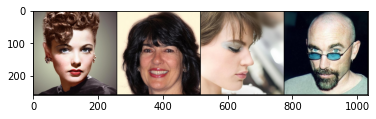

In [100]:
batch = next(iter(loader))
print(batch.shape)

show_tensor_images(batch)

In [114]:
batch = next(iter(loader))
print(batch[1])
print(batch[0].shape) # there are 64 images each of dimension 28X28 with just 1 channel
# print(batch[0])
unique_values = torch.unique(batch[0])
print(unique_values)
print(torch.min(batch[0]), torch.max(batch[0]))

tensor([[[-0.9216, -0.9373, -0.9294,  ..., -0.8745, -0.8745, -0.8745],
         [-0.9216, -0.9373, -0.9294,  ..., -0.8745, -0.8745, -0.8745],
         [-0.9137, -0.9294, -0.9294,  ..., -0.8745, -0.8745, -0.8745],
         ...,
         [ 0.2392,  0.2471,  0.1843,  ..., -0.7647, -0.7412, -0.7098],
         [ 0.2706,  0.2392,  0.2627,  ..., -0.7333, -0.7020, -0.6627],
         [ 0.2863,  0.2392,  0.2000,  ..., -0.6941, -0.6549, -0.6157]],

        [[-0.9216, -0.9373, -0.9294,  ..., -0.8745, -0.8745, -0.8745],
         [-0.9216, -0.9373, -0.9294,  ..., -0.8745, -0.8745, -0.8745],
         [-0.9137, -0.9294, -0.9294,  ..., -0.8745, -0.8745, -0.8745],
         ...,
         [-0.4039, -0.3882, -0.4275,  ..., -0.8431, -0.8353, -0.8118],
         [-0.3882, -0.4039, -0.3725,  ..., -0.8353, -0.8118, -0.7882],
         [-0.3882, -0.4118, -0.4431,  ..., -0.7961, -0.7725, -0.7569]],

        [[-0.9216, -0.9373, -0.9294,  ..., -0.8902, -0.8902, -0.8902],
         [-0.9216, -0.9373, -0.9294,  ..., -0

In [5]:
from tqdm.auto import tqdm
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_tensor_images(image_tensor, num_images=25, size=(3, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [118]:
# The generator will be composed of a series of 2d transpose convolutions - upsampling
class Generator(nn.Module):
    def __init__(self, z_dim=64, im_channels=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            self.make_generator_layer(z_dim, hidden_dim*16),
            self.make_generator_layer(hidden_dim*16, hidden_dim*8),
            self.make_generator_layer(hidden_dim*8, hidden_dim*4, output_padding=0),
            
            self.make_unet_layer(hidden_dim*4, hidden_dim*2),
            self.make_unet_layer(hidden_dim*2, hidden_dim),
            self.make_unet_layer(hidden_dim, im_channels, padding=3, final_layer=True)
        )
        
    def forward(self, noise):
        # print(f'Noise shape inside the generator : {noise.shape}')
        return self.generator(noise)
        
    def make_unet_layer(self, in_channels, out_channels, padding=2, kernel_size=3, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding),
                nn.Tanh()
            )
        
    def make_generator_layer(self, in_channels, out_channels, kernel_size=4, stride=2, output_padding=1):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, output_padding=output_padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
            
def sample_noise(batch_size=BATCH_SIZE, z_dim=64, device=device):
        return torch.randn(batch_size, z_dim).to(device)

In [102]:
inp = torch.randn(BATCH_SIZE, 10, 1, 1)
conv1 = nn.ConvTranspose2d(10, 1024, kernel_size=4, stride=2, output_padding=1)
conv2 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, output_padding=1)
conv3 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2)

# add the convolution operations corresponding to the UNET upsampling layers 
upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
conv4 = nn.Conv2d(256, 128, kernel_size=3, padding=2)
conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=2)

upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
conv6 = nn.Conv2d(128, 64, kernel_size=3, padding=2)
conv7 = nn.Conv2d(64, 64, kernel_size=3, padding=2)

upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
conv8 = nn.Conv2d(64, 32, kernel_size=3, padding=3)
conv9 = nn.Conv2d(32, 32, kernel_size=3, padding=3)


out = conv1(inp)
out1 = conv2(out)
out2 = conv3(out1)

up1 = upsample1(out2)
out3 = conv5(conv4(up1))
up2 = upsample2(out3)
out4 = conv7(conv6(up2))
up3 = upsample3(out4)
out5 = conv9(conv8(up3))
print(out.shape)
print(out1.shape)
print(f'Out2 shape : {out2.shape}')
print(up1.shape)
print(out3.shape)
print(up2.shape)
print(out4.shape)
print(up3.shape)
print(out5.shape)
# print(out5.shape)

torch.Size([4, 1024, 5, 5])
torch.Size([4, 512, 13, 13])
Out2 shape : torch.Size([4, 256, 28, 28])
torch.Size([4, 256, 56, 56])
torch.Size([4, 128, 60, 60])
torch.Size([4, 128, 120, 120])
torch.Size([4, 64, 124, 124])
torch.Size([4, 64, 248, 248])
torch.Size([4, 32, 256, 256])


torch.Size([4, 3, 256, 256])


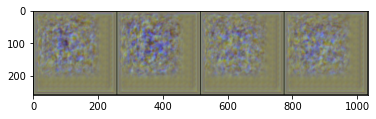

tensor(-0.7966, device='cuda:1', grad_fn=<MinBackward1>) tensor(0.7466, device='cuda:1', grad_fn=<MaxBackward1>)


In [119]:
gen = Generator().to(device)
noise = sample_noise()
# unsqueeze the noise 
noise = noise.view(len(noise), 64, 1, 1)
out = gen(noise)
print(out.shape) # batch size of 16, each image is of dimension 28x28 and has 1 channel
show_tensor_images(out)
print(torch.min(out), torch.max(out))

In [120]:
# The discriminator will be composed of 2d convolution operations - downsampling
# downsampling reduces the dimension and increases the number of channels in the image
class Discriminator(nn.Module):
    def __init__(self, im_channels=3, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            self.make_conv_layer(im_channels, hidden_dim),
            self.make_conv_layer(hidden_dim, hidden_dim*2),
            self.make_conv_layer(hidden_dim*2, hidden_dim*4),
            
            self.make_disc_layer(hidden_dim*4, hidden_dim*8),
            self.make_disc_layer(hidden_dim*8, hidden_dim*16),
            self.make_disc_layer(hidden_dim*16, 1, final_layer=True)
        )
        
    def forward(self, image):
        disc_pred = self.discriminator(image)
        return disc_pred.view(len(disc_pred), -1)
#         return self.discriminator(image)
        
    def make_conv_layer(self, in_channels, out_channels, kernel_size=3, stride=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
    def make_disc_layer(self, in_channels, out_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True) # saves memory doing it inplace, doesn't generate a new output
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride) # no activation required for the final layer
            )

In [64]:
disc = Discriminator().to(device)
image = torch.randn(BATCH_SIZE, 3, 256, 256).to(device)
classification = disc(image)
print(classification.shape)

# this generates a single classification score for all the imags in the batch
# we can integrate a patch based discriminator loss which generates a fake/real classification score for every patch of the image 

torch.Size([4, 1])


In [121]:
import torch.optim as optim

z_dim = 64
beta_1 = 0.5
beta_2 = 0.999
lr = 2e-4
epochs = 100

# binary classification loss for fake and real image
gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)
criterion = nn.BCEWithLogitsLoss()
gen_opt = optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc_opt = optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
# Weight initialization is really important
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Epoch : 0, step : 100, mean gen loss : 1.9187288004159928, mean disc loss : 0.28838238514959796


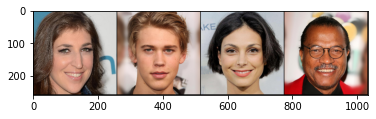

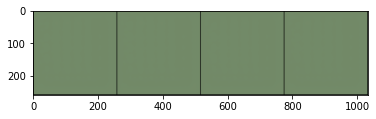

Epoch : 0, step : 200, mean gen loss : 3.7540980577468868, mean disc loss : 0.06003339506685736


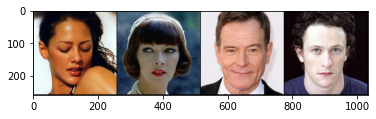

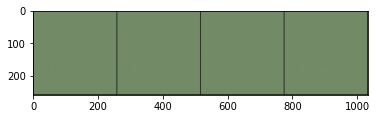

Epoch : 0, step : 300, mean gen loss : 4.335309207439424, mean disc loss : 0.033372828811407095


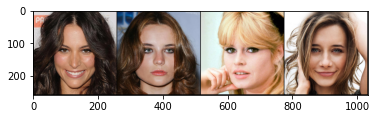

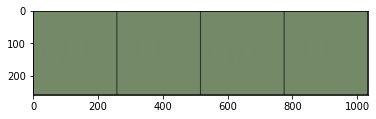

Epoch : 0, step : 400, mean gen loss : 4.773439710140227, mean disc loss : 0.02617257850244642


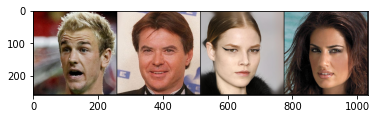

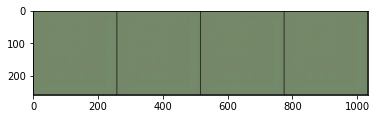

Epoch : 0, step : 500, mean gen loss : 5.15813227415085, mean disc loss : 0.025700956338550893


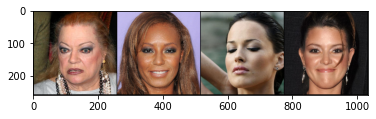

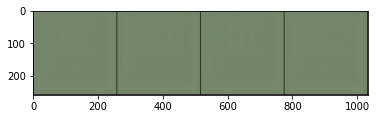

Epoch : 0, step : 600, mean gen loss : 5.246741781234741, mean disc loss : 0.01741308919619769


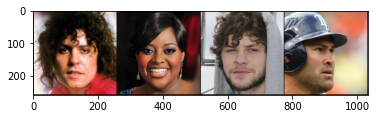

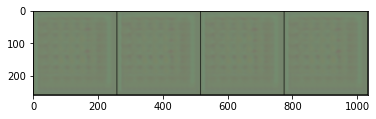

Epoch : 0, step : 700, mean gen loss : 5.7998623585701, mean disc loss : 0.0330073423939757


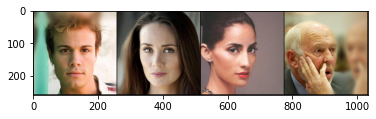

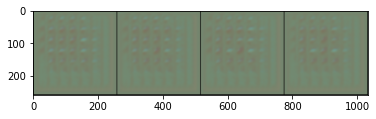

Epoch : 0, step : 800, mean gen loss : 5.055022916793825, mean disc loss : 0.09655570092785634


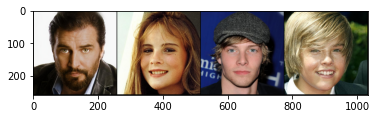

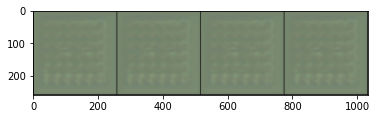

Epoch : 0, step : 900, mean gen loss : 5.049433805942535, mean disc loss : 0.27764386841561634


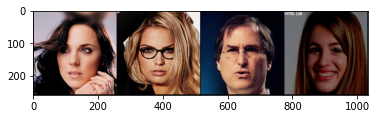

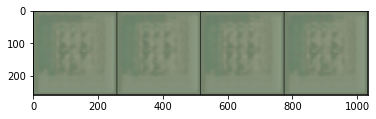

Epoch : 0, step : 1000, mean gen loss : 4.06885811805725, mean disc loss : 0.24845735361333943


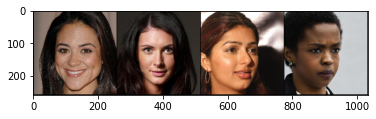

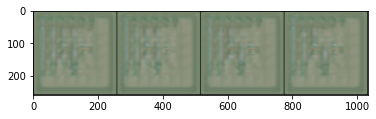

Epoch : 0, step : 1100, mean gen loss : 4.248300158977507, mean disc loss : 0.17992679296061403


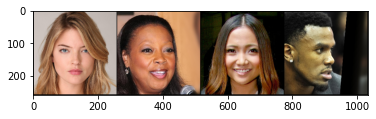

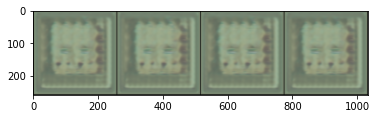

Epoch : 0, step : 1200, mean gen loss : 4.6253573513031, mean disc loss : 0.13116898767184465


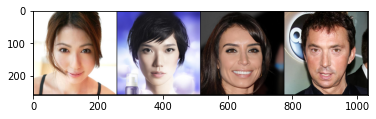

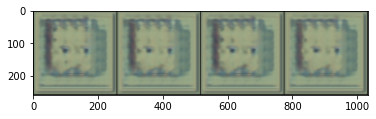

Epoch : 0, step : 1300, mean gen loss : 4.228196229934691, mean disc loss : 0.12293518588645384


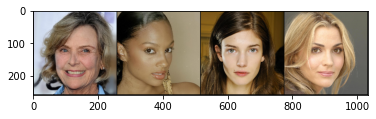

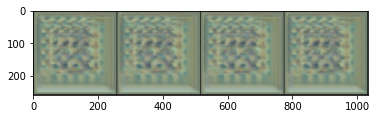

Epoch : 0, step : 1400, mean gen loss : 4.398581562042235, mean disc loss : 0.03392011166084557


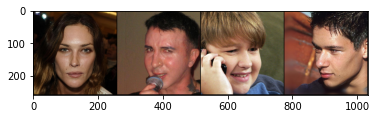

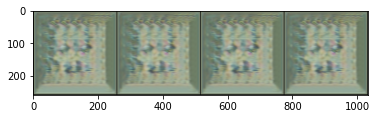

Epoch : 0, step : 1500, mean gen loss : 4.835227742195131, mean disc loss : 0.024756756371352814


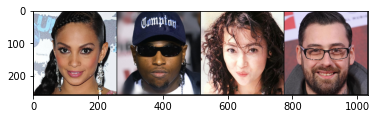

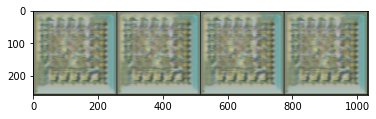

Epoch : 0, step : 1600, mean gen loss : 5.05558636665344, mean disc loss : 0.010910605862736702


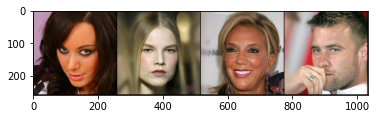

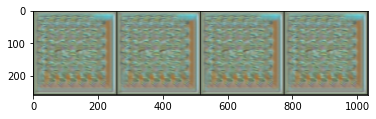

Epoch : 0, step : 1700, mean gen loss : 5.420624499320983, mean disc loss : 0.007693905758205801


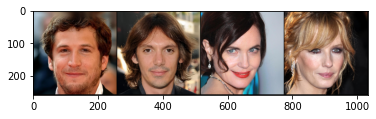

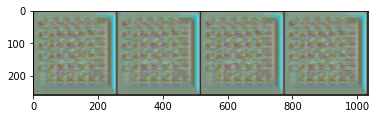

Epoch : 0, step : 1800, mean gen loss : 5.704923448562622, mean disc loss : 0.003571287462837062


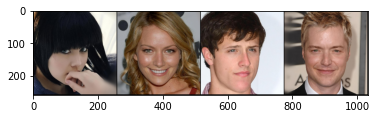

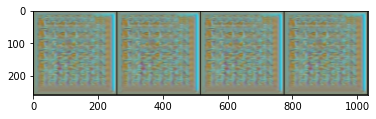

Epoch : 0, step : 1900, mean gen loss : 5.972052173614503, mean disc loss : 0.002666334437089973


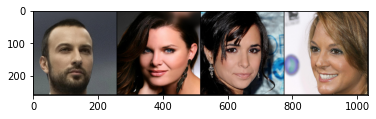

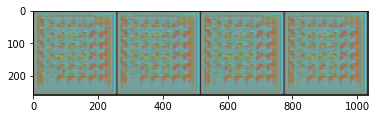

Epoch : 0, step : 2000, mean gen loss : 6.061528401374815, mean disc loss : 0.009452013975824233


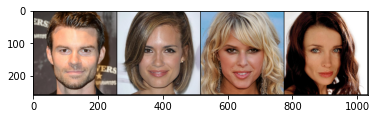

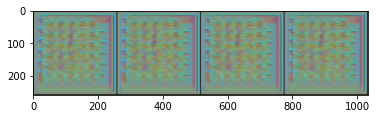

Epoch : 0, step : 2100, mean gen loss : 5.945003900527953, mean disc loss : 0.005703511373139917


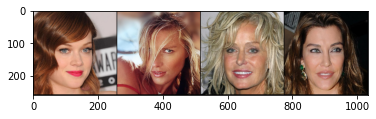

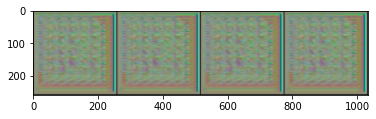

Epoch : 0, step : 2200, mean gen loss : 6.016881470680238, mean disc loss : 0.0022295864904299384


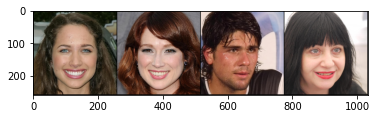

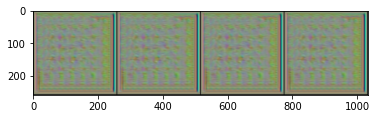

Epoch : 0, step : 2300, mean gen loss : 6.3237838757038105, mean disc loss : 0.13315441795886726


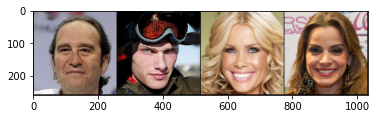

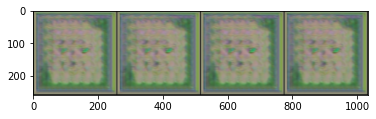

Epoch : 0, step : 2400, mean gen loss : 4.912603311538694, mean disc loss : 0.03503454638994299


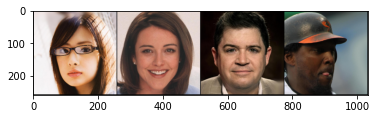

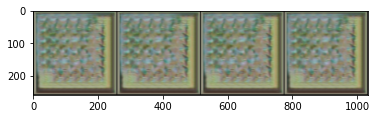

Epoch : 0, step : 2500, mean gen loss : 5.040706863254309, mean disc loss : 0.2638298211229265


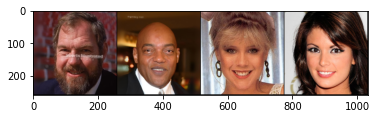

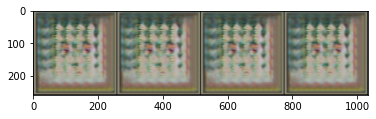

Epoch : 0, step : 2600, mean gen loss : 4.653437976837156, mean disc loss : 0.05622834723966662


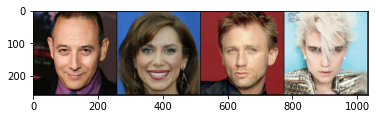

KeyboardInterrupt: 

In [123]:
mean_gen_loss = 0
mean_disc_loss = 0
step_size = 100
current_step = 0
eval_step_size = 200
for epoch in range(epochs):
    for index, real in enumerate(loader):
        # generate the discriminator classification on the real and fake images
        current_step += 1
        batch_size = real.shape[0]
        disc_opt.zero_grad()
        real = real.to(device)
        disc_real_pred = disc(real)
        noise = sample_noise(batch_size, z_dim, device)
        noise = noise.view(batch_size, z_dim, 1, 1)
        fake = gen(noise) # dimension -> batch_size x im_channels x height x width
        
        disc_fake_pred = disc(fake.detach()) # gradients shouldn't backpropagate to the generator
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss)/2
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        
        gen_opt.zero_grad()
        noise = sample_noise(batch_size, z_dim, device)
        noise = noise.view(batch_size, z_dim, 1, 1)
        fake = gen(noise)
        disc_fake_pred = disc(fake)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()
        
        mean_disc_loss += disc_loss.item() / step_size
        mean_gen_loss += gen_loss.item() / step_size
        
        if current_step % step_size == 0:
            print(f'Epoch : {epoch}, step : {current_step}, mean gen loss : {mean_gen_loss}, mean disc loss : {mean_disc_loss}')
            mean_disc_loss = 0
            mean_gen_loss = 0
    
            show_tensor_images(real)
            show_tensor_images(fake)

In [ ]:
# The images in the VQVAE2 dataset are of the dimension -> (batch_size x 3 x )